In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn import metrics
from sklearn.metrics import r2_score, accuracy_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import StandardScaler, PowerTransformer

from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

%matplotlib inline

In [323]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

## Import,Clean Data & Feature Engineering

In [324]:
user_df=pd.read_csv('takehome_users.csv',encoding = "ISO-8859-1")

In [325]:
user_df['creation_time']=pd.to_datetime(user_df['creation_time'])

In [326]:
user_df['last_session_creation_time']=(pd.to_timedelta(user_df['last_session_creation_time'], 
                                                       unit='s')+ dt.datetime(1970, 1,1)).dt.date
                                       
user_df['last_session_creation_time']=pd.to_datetime(user_df['last_session_creation_time'])

In [334]:
user_eng_df=pd.read_csv('takehome_user_engagement.csv')  #,encoding = "ISO-8859-1")
user_eng_df.time_stamp=pd.to_datetime(user_eng_df['time_stamp'])
#user_eng_df.drop('time_stamp',axis=1,inplace=True)

In [335]:
ids=list(user_eng_df.user_id.value_counts().sort_index().index)

In [337]:
adopted=pd.DataFrame({'user_id':ids,'Adopted':np.zeros_like(ids)})
for id in ids:
    df=user_eng_df.loc[user_eng_df['user_id']==id,:]
    df=df.sort_values(by='time_stamp')
    
    if df.shape[0]>2:
        first=0
        date_1st=df['time_stamp'].iloc[0]
        df['days'] = (df['time_stamp']-date_1st).dt.days.astype(int)
        df['cumsum_visits'] = df['visited'].cumsum()
        df=df.loc[df.cumsum_visits%3==0,:]

        first=df['days'].iloc[0]
        df['days']=df.days.diff()
        df['days'].fillna(first,inplace=True)

        if (df.days<=7).sum()>0:
            adopted.loc[adopted['user_id']==id,'Adopted']=1
#(user_eng_df.last_trip_date.max()-challenge_df.last_trip_date).dt.days

In [338]:
adopted.Adopted.value_counts()

0    7482
1    1341
Name: Adopted, dtype: int64

In [441]:
adopted.Adopted.value_counts()/8823

0    0.848011
1    0.151989
Name: Adopted, dtype: float64

In [341]:
adopted.head()

,user_id,Adopted
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [342]:
user_df.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,2013-03-19,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,2013-05-22,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,2013-01-22,0,0,193,5240.0


In [359]:
cols=['object_id','name', 'email', 'org_id','invited_by_user_id']
combined_df=adopted.merge(user_df,how='left',right_on='object_id',left_on='user_id')
combined_df.drop(columns=cols,axis=1,inplace=True)

In [364]:
#check on missing values
combined_df.isna().sum()

user_id                       0
Adopted                       0
creation_time                 0
creation_source               0
last_session_creation_time    0
opted_in_to_mailing_list      0
enabled_for_marketing_drip    0
dtype: int64

In [366]:
combined_df.nunique()

user_id                       8823
Adopted                          2
creation_time                 8821
creation_source                  5
last_session_creation_time     736
opted_in_to_mailing_list         2
enabled_for_marketing_drip       2
dtype: int64

In [365]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 0 to 8822
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     8823 non-null   int64         
 1   Adopted                     8823 non-null   int32         
 2   creation_time               8823 non-null   datetime64[ns]
 3   creation_source             8823 non-null   object        
 4   last_session_creation_time  8823 non-null   datetime64[ns]
 5   opted_in_to_mailing_list    8823 non-null   int64         
 6   enabled_for_marketing_drip  8823 non-null   int64         
dtypes: datetime64[ns](2), int32(1), int64(3), object(1)
memory usage: 517.0+ KB


In [367]:
#check on duplicated rows
combined_df.duplicated().sum()

0

In [371]:
current_date=combined_df.last_session_creation_time.max()

In [376]:
#Define 'age' (how long ago did the user signup)
#Define 'last_login' (how long ago was the user's last login) 

combined_df['age']=(current_date-combined_df.creation_time).dt.days
combined_df['last_login']=(current_date-combined_df.last_session_creation_time).dt.days
combined_df.drop(['creation_time','last_session_creation_time'],axis=1,inplace=True)

In [377]:
combined_df.head()

,user_id,Adopted,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,age,last_login
0,1,0,GUEST_INVITE,1,0,44,45
1,2,0,ORG_INVITE,0,0,202,67
2,3,0,ORG_INVITE,0,0,443,444
3,4,0,GUEST_INVITE,0,0,380,380
4,5,0,GUEST_INVITE,0,0,504,500


# EDA

In [403]:
def barplot_cat(x="Adopted", y="proportion", hue=hue):
    gfg=(combined_df[hue]
         .groupby(combined_df[x])
         .value_counts(normalize=True)
         .rename(y)
         .reset_index()
         .pipe((sns.barplot, "data"), x=x, y=y, hue=hue))
    plt.setp(gfg.get_legend().get_texts(), fontsize='5') 
    gfg.legend(bbox_to_anchor= (1.5,1))

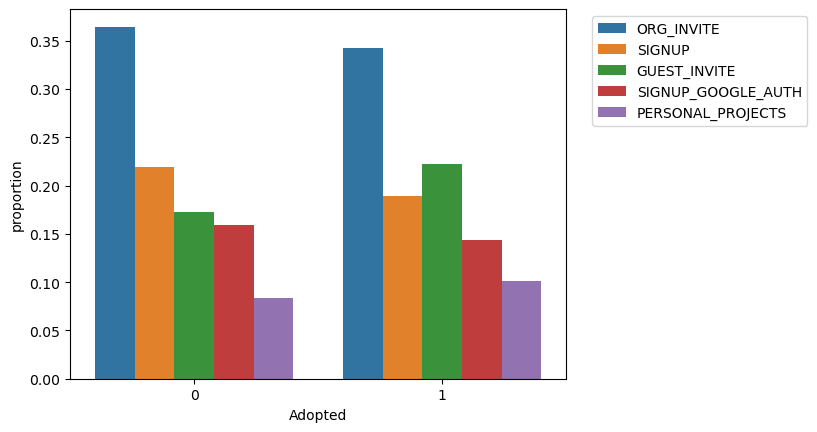

In [404]:
hue='creation_source'
barplot_cat(hue=hue)

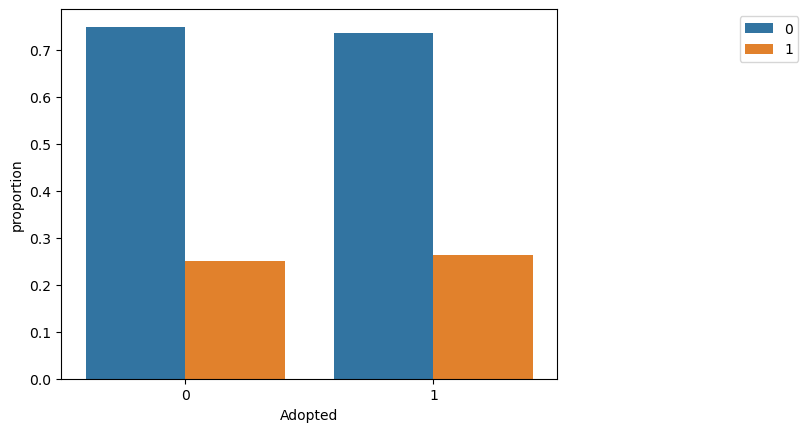

In [405]:
hue='opted_in_to_mailing_list'
barplot_cat(hue=hue)

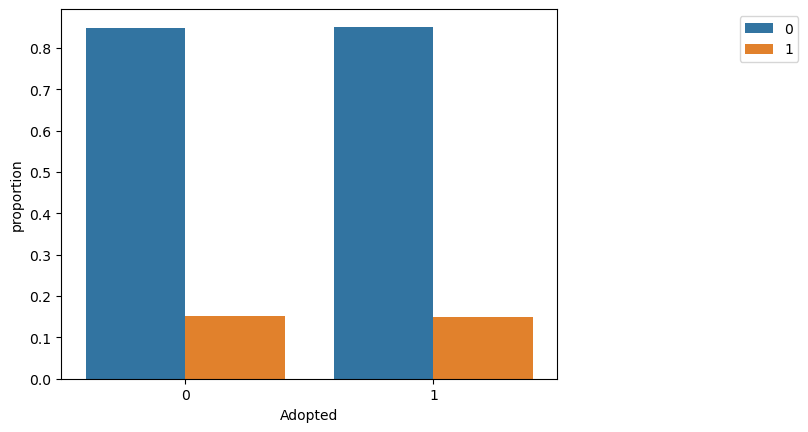

In [406]:
hue='enabled_for_marketing_drip'
barplot_cat(hue=hue)

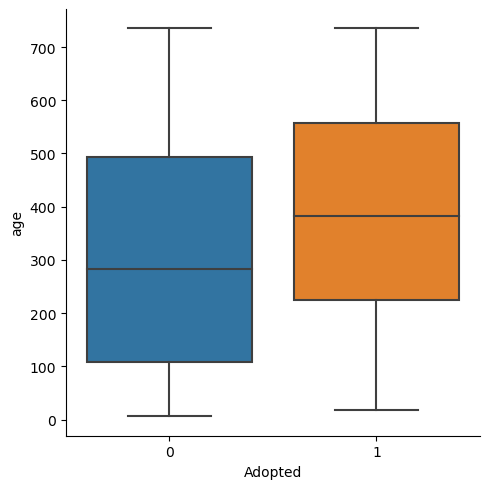

In [415]:
sns.catplot(x="Adopted",y='age',data=combined_df, kind='box')

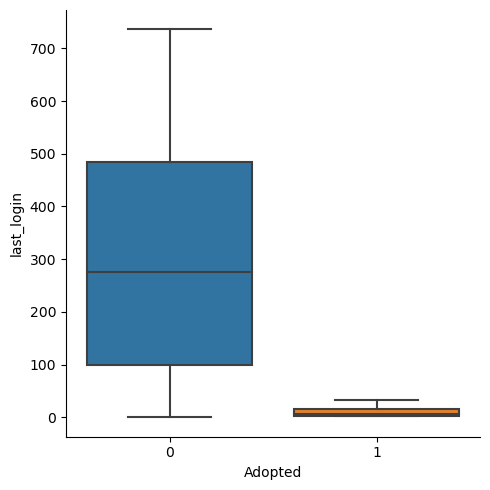

In [419]:
sns.catplot(x="Adopted",y='last_login',data=combined_df, kind='box',showfliers=False)

# Pre-processing

In [420]:
combined_df.columns

Index(['user_id', 'Adopted', 'creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'age', 'last_login'],
      dtype='object')

In [421]:
cols=['creation_source', 'opted_in_to_mailing_list','enabled_for_marketing_drip']                   
combined_df=pd.get_dummies(combined_df,drop_first=True,columns=cols,dtype=float)

In [422]:
combined_df.head()

,user_id,Adopted,age,last_login,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,opted_in_to_mailing_list_1,enabled_for_marketing_drip_1
0,1,0,44,45,0.0,0.0,0.0,0.0,1.0,0.0
1,2,0,202,67,1.0,0.0,0.0,0.0,0.0,0.0
2,3,0,443,444,1.0,0.0,0.0,0.0,0.0,0.0
3,4,0,380,380,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,504,500,0.0,0.0,0.0,0.0,0.0,0.0


In [423]:
X=combined_df.drop(columns=['user_id', 'Adopted'],axis=1)
y=combined_df['Adopted']

In [424]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y,random_state=123)
print('X_train : ',X_train.shape)
print('X_test : ',X_test.shape)

unique,count=np.unique(y_train, return_counts=True)
print('train_test sets are splited with stratification: \n\t training set: {} '.format(count/len(y_train)))
unique1,count1=np.unique(y_test, return_counts=True)
print('train_test sets are splited with stratification: \n\t test set: {} '.format(count1/len(y_test)))

X_train :  (7940, 8)
X_test :  (883, 8)
train_test sets are splited with stratification: 
	 training set: [0.84798489 0.15201511] 
train_test sets are splited with stratification: 
	 test set: [0.84824462 0.15175538] 


In [425]:
cols=['age', 'last_login']

scaler = PowerTransformer()
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.transform(X_test[cols])

# Train Model

## LogisticRegression Classification

Base Model : 
[[743   6]
 [ 25 109]]
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       749
           1       0.95      0.81      0.88       134

    accuracy                           0.96       883
   macro avg       0.96      0.90      0.93       883
weighted avg       0.96      0.96      0.96       883



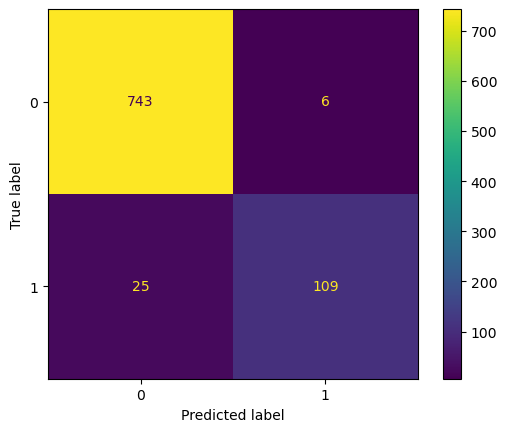

In [426]:
logit_clf= LogisticRegression(penalty='l2',random_state = 0) 
logit_clf.fit(X_train,y_train)
y_pred=logit_clf.predict(X_test)

pl = confusion_matrix(y_test,y_pred)
print("Base Model : \n{}".format(pl))

print(classification_report(y_test,y_pred))

dist=ConfusionMatrixDisplay(confusion_matrix=pl,display_labels=logit_clf.classes_)
dist.plot()

## Feature Importance

Text(0, 0.5, 'Relative Importance')

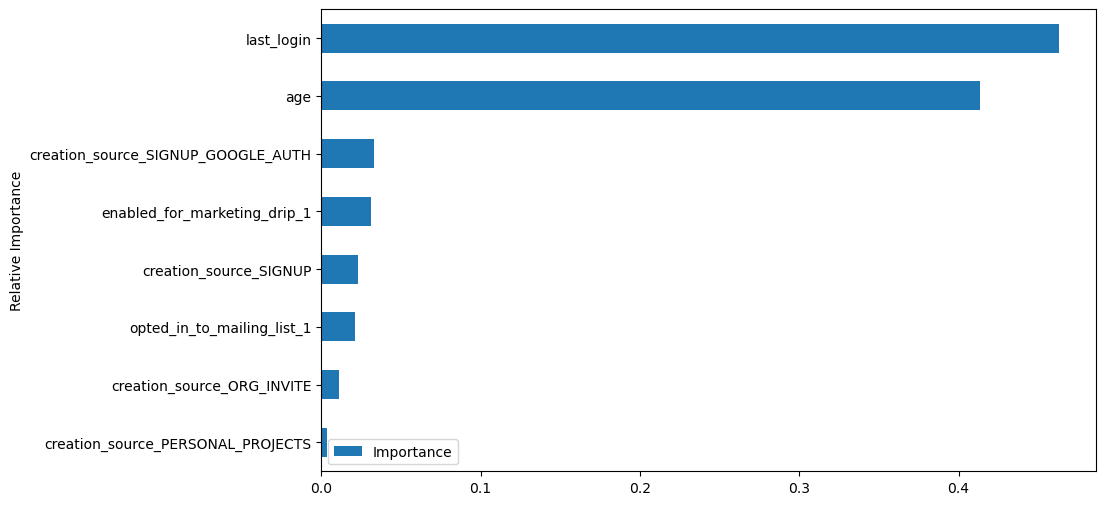

In [427]:
##feature importance plot
model=logit_clf
coefficients = model.coef_

avg_importance = np.mean(np.abs(coefficients), axis=0)
feature_importance = pd.DataFrame({'Feature': X_train.columns, 'Importance': avg_importance/np.sum(avg_importance)})
feature_importance = feature_importance.sort_values('Importance', ascending=True)
feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
plt.ylabel('Relative Importance')

In [440]:
coef_df=pd.DataFrame({'features':list(X_train.columns), 'coef':list(coefficients.reshape(-1))})
coef_df

,features,coef
0,age,4.365790
1,last_login,-4.895352
2,creation_source_ORG_INVITE,-0.118955
3,creation_source_PERSONAL_PROJECTS,0.041045
4,creation_source_SIGNUP,-0.240982
5,creation_source_SIGNUP_GOOGLE_AUTH,-0.352389
6,opted_in_to_mailing_list_1,0.222724
7,enabled_for_marketing_drip_1,-0.328895


# Summary of Findings

1.In  “takehome_user_engagement” file, there are only 8823 unique users, and therefore we were only able to determine the 8823 user’s adoption of the product. Among the 8823 users, about 84.8% users did not adopt the product and only about 15.2% users did adopt the product. There is no missing values in the “takehome_user” file for the 8823 users.


2.Features such as 'object_id','name', 'email', 'org_id','invited_by_user_id' were dropped before further data exploration  and only features such as 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'creation_time', 'last_login_creation_time' were entered for classification. At EDA step, I examined bi-variate correlation between each feature with the target variable ‘adoption’. As can been seen from the barplots presented  in EDA section,  there is no clear correlation between the target feature with  'enabled_for_marketing_drip' or  'last_login_creation_time' . Distribution of “creation_source” showed very little difference between users who adopted the product and users who did not. Visually examination of the boxplots of Creation_time and last_login_creation_time showed very distinct distributions between two groups. 


3.I applied logistic regression for classification, at 80/20 train/test split.  The model performs quite well. The following is a summary of performance of the modeling method.

                  Adpotion	precision	recall	f1-score
                       Yes	     0.97	  0.99	    0.98
                        No	     0.95	  0.81	    0.88
                  accuracy		                    0.96	
                 macro avg	     0.96	  0.90	    0.93
              weighted avg	     0.96	  0.96	    0.96

4.The most important factor in predicting whether the user will adopt the product is how long ago the user last logged into the product, the more recent the user's last login is, the more likely the user will adopt the product. The second most important factor in predicting adoption of the product by user is the elapsed time from the user first created login. The longer history the user has with the product, the more likely the user will adopt the product. Factors such as how the user's account was created, whether the user has opted into receiving marketing emails, and whether the user is on the regular marketing email drip seem to have very little impact on predicting adoption of the product by the user, which is consistent with our observation in EDA step.  Feature importance are ranked and plotted in Feature Importance Plot in Section Train Model/Feature Importance. 